In [166]:
import pandas as pd

from datetime import datetime
from more_itertools import windowed

import seaborn as sns
sns.set()

В следующем абзаце парсится rfm.tsv. В нём содержатся символы, которые ломают парсер utf-8, поэтому пришлось подкостылить кодировку. По той же причине не работает нормально read_table. Эти символы зашиты куда-то в категории в строчках, которые не click, так что для этого анализа они не оч интересны.

Хэдера тоже нет, добавил руками. Если что, порядок добавления элементов в словарь сохраняется с 3.7, так что rfm_dtypes.keys() возвращает ключи в указанном порядке.

Обнуление data_list в конце -- кивок в сторону garbage collector, чтобы лишние сотни мб не висели в оперативке.

In [167]:
rfm_dtypes = {
    'timestamp': int,
    'user_id': str,
    'url': str,
    'geo_id': int,
    'category': int,
    'price': int
}

data_list = []
with open('rfm.tsv', encoding='cp1251') as rfm_file:
    for line in rfm_file:
        values = line.strip('\n').split('\t')
        line_data = dict(zip(rfm_dtypes.keys(), values))
        if line_data['url'] != 'click':
            continue
        del line_data['url']
        line_data = {key: rfm_dtypes[key](value) for key, value in line_data.items()}
        data_list.append(line_data)

df = pd.DataFrame(data_list)
data_list = None

In [168]:
geo = pd.read_table('geo_table.tsv')
categories = pd.read_table('categories_tree.tsv')

In [169]:
df.tail()

,timestamp,user_id,geo_id,category,price
363308,1363707700,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,31
363309,1363707492,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,37
363310,1363708054,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,37
363311,1363707459,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,45
363312,1360163592,ffffda42ccd5f1ed15a700b23fc6c8e5,39,91491,16


In [170]:
geo.tail()

,id,name,parent_region_id,type,TZ_OFFSET
51661,127495,Котельников,99244.0,7,10800
51662,127496,Красноярский,99244.0,7,10800
51663,127497,Майоровский,99244.0,7,10800
51664,127498,Нагавская,99244.0,7,10800
51665,127499,Нагольный,99244.0,7,10800


In [171]:
categories.tail()

,id,parent_id,hyper_cat_id,category_name,category_pass
1930,26387,23650,13061828,Клей,\tВсе для офиса\tРасходные материалы\tКлей\t
1931,84,23650,91046,Бумага и пленка,\tВсе для офиса\tРасходные материалы\tБумага и...
1932,18585,23650,6268029,Расходные материалы для брошюровщиков,\tВсе для офиса\tРасходные материалы\tРасходны...
1933,509,23650,90741,Скотч,\tВсе для офиса\tРасходные материалы\tСкотч\t
1934,510,23650,90742,"Скрепки, кнопки","\tВсе для офиса\tРасходные материалы\tСкрепки,..."


In [172]:
df['dttm'] = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

In [173]:
min(df.dttm), max(df.dttm)

(Timestamp('2012-12-31 20:09:40'), Timestamp('2013-12-31 19:56:08'))

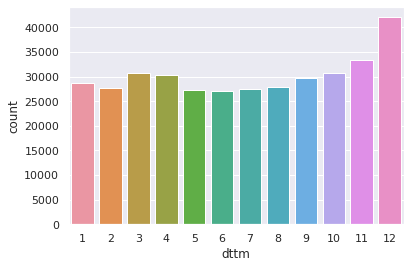

In [174]:
sns.countplot(df.dttm.dt.month)

R, recency, -- как давно человек совершал покупку. Подсчёт метрики выглядит straightforward, значительно интереснее понять, как правильно делить людей на классы по недавности. Следующий кусок кода вычисляет сдвиги по времени между кликами отдельного пользователя.

In [175]:
df_r = df[['user_id', 'dttm']].copy().sort_values(by=['user_id', 'dttm'], ascending=[True, True])
df_r = df_r.reset_index(drop=True)
df_r['user_id'] = df_r.user_id.apply(lambda x: int(x, 16))

df_diff = df_r.diff().dropna().reset_index(drop=True)
df_diff = df_diff[df_diff.user_id == 0]

Ну и по сдвигам имеет смысл посчитать квантили. Я выбросил разницы меньше дня, отнеся их к одному посещению сайта. В плане recency нас слабо интересует происходящее в рамках одного подхода, зато огромное количество последовательных кликов давит всю остальную статистику обращений.

In [176]:
qs = [x / 4 for x in range(4)] + [1]
recency_edges = df_diff[df_diff.dttm.dt.days != 0].dttm.dt.days.quantile(qs).tolist()
recency_edges

[1.0, 3.0, 8.0, 25.0, 347.0]

25% квантиль -- 3 дня, 50% -- 8 дней. Тут есть большое желание обратиться к бизнесу и выяснить, чем пользователи на самом деле занимаются, что в 25% случаев они возвращаются в течение пары дней (важно: случаев, а не клиентов). Но в целом, даже на этом уровне хочется кидать напоминалки на почту через 3 и 7 дней. Какие именно -- нужно посмотреть, но навскидку стоит потестить вариации "ты шопился и бросил, возвращайся к тем же товарам" и "вероятно, ты купил нужное, но тебя наверняка заинтересуют смежные товары".

(Под "обратиться к бизнесу" имеется в виду как непосредственное обращение к людям, которые исследовали вопрос, так и разбиение этих же данных по корневым категориям из соседнего файла и просмотр глазками происходящего.)

Пока договоримся, что в терминах rfm меньше трёх дней -- свежачок, от 3 до 8 начинают отваливаться, от 8 до 25 -- теряющие интерес, и свыше 25 -- потерянные. Начинающим отваливаться напоминалки, теряющим интерес и "хорошим" по частоте/монетизации можно акций покидать, потерянных исследовать отдельно (какая часть из них ЦА и почему она отваливается). Всем программы лояльности, чтобы стрёмно было к конкурентам уходить.

Функция вычисления RFM.

Деление F и M на части происходит по квантилям, на указанное число частей. R делится как описано выше.

R = число дней с последней покупки клиента до конца 2013 (считаем это моментом анализа).

F = число покупок в год. Нужно бы считать что-то типа взвешенного среднего числа покупок в месяц, с затуханием влияния старых месяцев, но с таким подходом есть свои проблемы (большое R убьёт F, например, так что нужно бы считать F на момент выхода из обслуживания... ещё подумаю над этим).

M = медиана стоимости клика по пользователю. Но в данном кейсе я в эту метрику не верю, непонятно, почему она должна предсказывать поведение пользователя.

In [177]:
def rfm_quantiles(df, parts=4, dttm_name='dttm', price_name='price', user_name='user_id'):
    rfm = {user: {} for user in set(df[user_name])}
    
    qs = [x / parts for x in range(parts)] + [1]
    monetary = df[[user_name, price_name]].groupby(user_name, as_index=False).median()
    monetary_edges = monetary[price_name].quantile(qs).tolist()
    for record in monetary.to_dict('records'):
        for m, (left, right) in enumerate(windowed(monetary_edges, n=2)):
            if right >= record[price_name] >= left:
                rfm[record[user_name]]['m'] = m
                break
    
    frequency = df[[user_name, price_name]].groupby(user_name, as_index=False).count()
    frequency = frequency.rename(columns={price_name: 'count'})
    frequency_edges = frequency['count'].quantile(qs).tolist()
    for record in frequency.to_dict('records'):
        for f, (left, right) in enumerate(windowed(frequency_edges, n=2)):
            if right >= record['count'] >= left:
                rfm[record[user_name]]['f'] = f
                break
    
    recency = df[[user_name, dttm_name]].sort_values(by=[user_name, dttm_name], ascending=True)
    recency = recency.groupby(user_name, as_index=False).last()
    recency['diff'] = (datetime(year=2014, month=1, day=1) - recency[dttm_name]).dt.days
    recency_edges = [0.0, 3.0, 8.0, 25.0, 365.0]
    for record in recency.to_dict('records'):
        for r, (left, right) in enumerate(windowed(recency_edges, n=2)):
            if right >= record['diff'] >= left:
                rfm[record[user_name]]['r'] = r
                break
    
    return rfm, {'recency_edges': recency_edges,
                 'monetary_edges': monetary_edges,
                 'frequency_edges': frequency_edges}

In [178]:
rfm, edges = rfm_quantiles(df)

In [179]:
rfm

{'a33fb56b58e5468d61044bad8726b9d5': {'m': 0, 'f': 2, 'r': 3},
 '9cf2352eb67cfe5d4de94f99db0ce810': {'m': 2, 'f': 1, 'r': 2},
 '39b1793e6619602727d9795c6bbe6ddb': {'m': 0, 'f': 3, 'r': 1},
 'dcf0934d581a24f6cbfa5785d19c8eab': {'m': 0, 'f': 3, 'r': 3},
 'aed24d88857b076a6ed67d8247840cc6': {'m': 3, 'f': 0, 'r': 0},
 '7fd5c48f32099ea3a47be424b0e80202': {'m': 3, 'f': 0, 'r': 3},
 '702b2252779fdb1c37cc25999242844b': {'m': 0, 'f': 0, 'r': 3},
 'f479ffe52a71239dfcd2d576c9dd2040': {'m': 0, 'f': 2, 'r': 3},
 '497a6a5b6136894ab7460af1e7fb4f2f': {'m': 0, 'f': 0, 'r': 3},
 'b37a7c369d196d66781645a7fe994986': {'m': 0, 'f': 3, 'r': 3},
 'ffceb438810e217ce2fcbaf734167ee8': {'m': 0, 'f': 0, 'r': 3},
 '4bec62b29c5edc5b9ae2db3ec4b2bcf3': {'m': 2, 'f': 1, 'r': 3},
 '58dc8a56a2087a3f06626116c54cb1d9': {'m': 2, 'f': 3, 'r': 3},
 '9d5325cb8966f36b6afa049270a2d2c3': {'m': 0, 'f': 0, 'r': 3},
 '14dda29c0d2ab7e892ef80e7b7a15c3a': {'m': 3, 'f': 1, 'r': 3},
 'ee5b49613b46cb0794f0a3f14e701f57': {'m': 0, 'f': 0, '

In [180]:
df[df.user_id == '9cf2352eb67cfe5d4de94f99db0ce810']  # rfm 212

,timestamp,user_id,geo_id,category,price,dttm
221296,1385667630,9cf2352eb67cfe5d4de94f99db0ce810,213,90594,31,2013-11-28 19:40:30
221297,1386967592,9cf2352eb67cfe5d4de94f99db0ce810,213,91259,10,2013-12-13 20:46:32


In [181]:
edges

{'recency_edges': [0.0, 3.0, 8.0, 25.0, 365.0],
 'monetary_edges': [0.0, 10.0, 11.0, 25.0, 1000.0],
 'frequency_edges': [1.0, 1.0, 2.0, 5.0, 2356.0]}